# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [8]:
# ---- Imports ----
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt

penguins = sns.load_dataset('penguins')
target = 'species'

X_raw = penguins.drop(columns=[target])
y = penguins[target]

mask = y.notna()
X_raw = X_raw.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)


numeric_cols = selector(dtype_include=['int64', 'float64'])(X_raw)
categorical_cols = selector(dtype_include=['object', 'category'])(X_raw)

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),
    ]
)

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

=== Overall Summary (sorted by Accuracy) ===
                      Model  Overall Accuracy  AUC[Adelie]  AUC[Chinstrap]  AUC[Gentoo]
                  KNN (k=7)          1.000000     1.000000             1.0     1.000000
  Decision Tree (unlimited)          1.000000     1.000000             1.0     1.000000
                  KNN (k=5)          0.985507     1.000000             1.0     1.000000
Decision Tree (max_depth=4)          0.985507     0.983333             1.0     0.988636 

=== KNN (k=5) — Confusion Matrix (rows=true, cols=pred) ===
           Adelie  Chinstrap  Gentoo
Adelie         29          1       0
Chinstrap       0         14       0
Gentoo          0          0      25 

=== KNN (k=5) — Classification Report ===
              precision    recall  f1-score   support

      Adelie      1.000     0.967     0.983        30
   Chinstrap      0.933     1.000     0.966        14
      Gentoo      1.000     1.000     1.000        25

    accuracy                          0.986

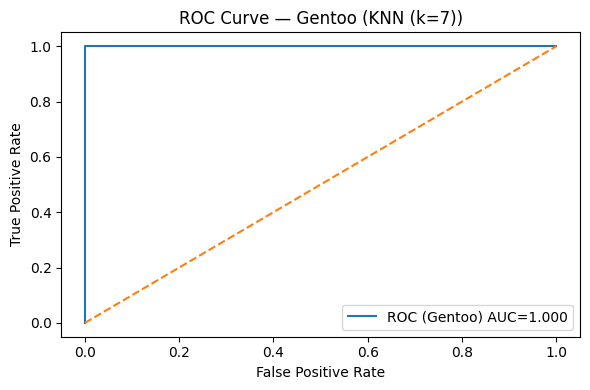

In [9]:


X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)


models = {
    'KNN (k=5)': Pipeline([
        ('prep', preprocess),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),
    'KNN (k=7)': Pipeline([
        ('prep', preprocess),
        ('clf', KNeighborsClassifier(n_neighbors=7))
    ]),
    'Decision Tree (max_depth=4)': Pipeline([
        ('prep', preprocess),
        ('clf', DecisionTreeClassifier(max_depth=4, random_state=42))
    ]),
    'Decision Tree (unlimited)': Pipeline([
        ('prep', preprocess),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
}


all_reports = {}      # classification report text per model
all_confusions = {}   # confusion matrices per model
summary_rows = []     # overall accuracy & macro metrics
per_class_auc = {}    # per-class AUCs per model

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Basic metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=pipe.named_steps['clf'].classes_)
    report_txt = classification_report(y_test, y_pred, digits=3)

    all_confusions[name] = (pipe.named_steps['clf'].classes_, cm)
    all_reports[name] = report_txt

    # AUC (One-vs-Rest) requires probabilities
    # Not all classifiers support predict_proba; KNN & DT do.
    y_test_bin = label_binarize(y_test, classes=pipe.named_steps['clf'].classes_)
    y_proba = pipe.predict_proba(X_test)
    cls_names = list(pipe.named_steps['clf'].classes_)
    aucs = {}
    for i, cls in enumerate(cls_names):
        aucs[cls] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    per_class_auc[name] = aucs

    # Summarize overall + macro averages for convenience
    # (You already have per-class P/R/F1 in report_txt)
    summary_rows.append({
        'Model': name,
        'Overall Accuracy': acc,
        **{f'AUC[{cls}]': aucs[cls] for cls in cls_names}
    })

summary_df = pd.DataFrame(summary_rows).sort_values('Overall Accuracy', ascending=False)
summary_df.reset_index(drop=True, inplace=True)

# Display a tidy summary
print("=== Overall Summary (sorted by Accuracy) ===")
print(summary_df.to_string(index=False), "\n")

# Show per-model confusion matrices and classification reports
for name in models.keys():
    classes, cm = all_confusions[name]
    print(f"=== {name} — Confusion Matrix (rows=true, cols=pred) ===")
    print(pd.DataFrame(cm, index=classes, columns=classes), "\n")
    print(f"=== {name} — Classification Report ===")
    print(all_reports[name])


species_to_plot = 'Gentoo'

best_model_name = summary_df.iloc[0]['Model']  # pick the best (by accuracy) for plotting
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
proba = best_model.predict_proba(X_test)
classes = list(best_model.named_steps['clf'].classes_)
y_test_bin = label_binarize(y_test, classes=classes)

if species_to_plot not in classes:
    raise ValueError(f"'{species_to_plot}' not found in classes {classes}")

i = classes.index(species_to_plot)
fpr, tpr, thresh = roc_curve(y_test_bin[:, i], proba[:, i])
auc_val = roc_auc_score(y_test_bin[:, i], proba[:, i])

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC ({species_to_plot}) AUC={auc_val:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve — {species_to_plot} ({best_model_name})')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
